## Importación principales librerias

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

## Importación de datos

In [2]:
df = pd.read_csv('../data/calidad_clean_outliers.csv', delimiter=',')
df = df[['FECHA', 'O3']]
df["ICA_LOG"] = df["O3"].apply(np.log)
df["ICA_LOG_diff"] = df["ICA_LOG"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
#df["FECHA"] = pd.to_datetime(df["FECHA"], format = "%Y")
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d %H:%M:%S")
df.set_index("FECHA", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head(2)

,O3,ICA_LOG,ICA_LOG_diff
FECHA,,,
2019-01-01 06:00:00,7.97,2.075684,-0.399172
2019-01-01 07:00:00,9.32,2.232163,0.156478


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30859 entries, 2019-01-01 06:00:00 to 2023-05-31 23:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   O3            30859 non-null  float64
 1   ICA_LOG       30859 non-null  float64
 2   ICA_LOG_diff  30859 non-null  float64
dtypes: float64(3)
memory usage: 964.3 KB


## Análisis exploratorio de datos

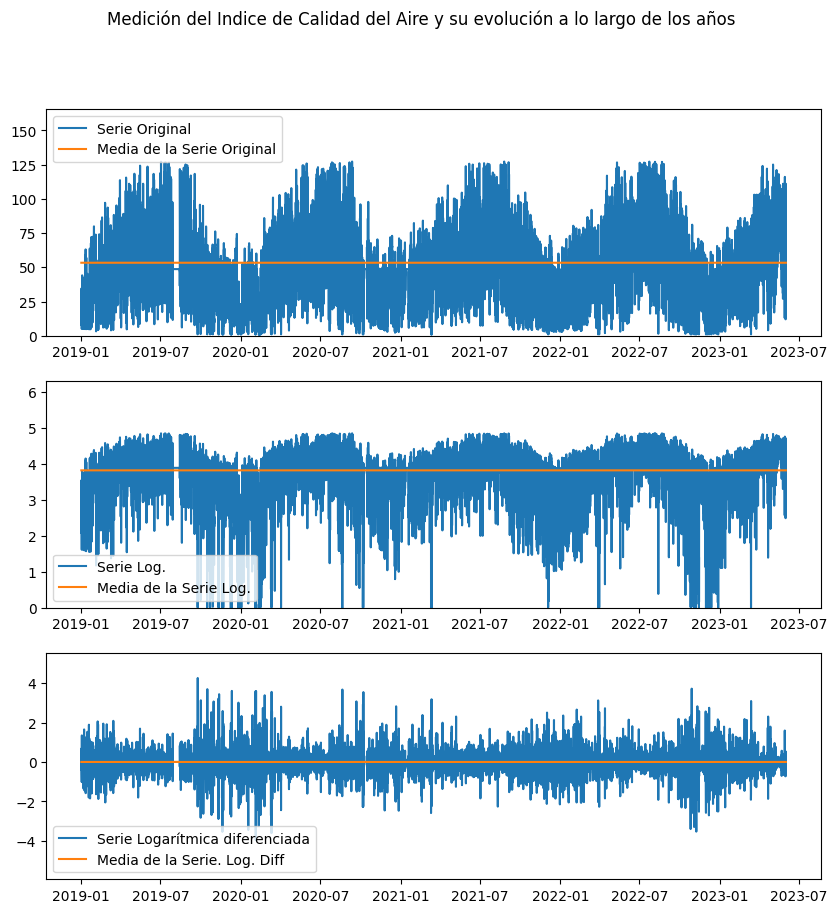

In [5]:


# separar x y la y para el gráfico
x = df.index

y = df["O3"]
y_media = [np.mean(y) for _ in y]

y_log = df["ICA_LOG"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = df["ICA_LOG_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_media, label = "Media de la Serie Log.")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Serie Logarítmica diferenciada")
ax3.plot(x, y_log_diff_mean, label = "Media de la Serie. Log. Diff")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Medición del Indice de Calidad del Aire y su evolución a lo largo de los años");



## Comprobación de la estacionaridad de la serie

In [6]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -9.711478387596035

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.0088506692338302e-16

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -11.196833145912365

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 2.2953343480792922e-20

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -38.07185376322272

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0



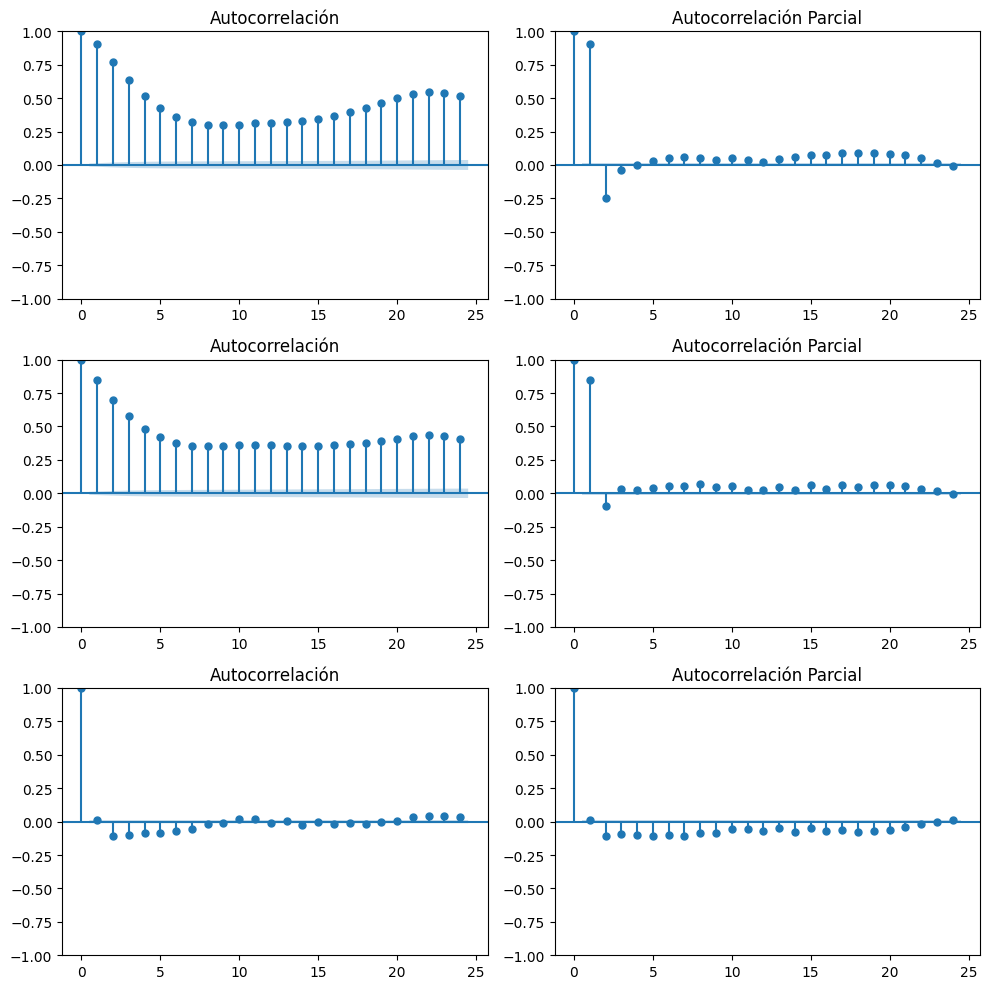

In [7]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()



Si nos fijamos en los gráficos que obtenemos, vemos que hay para la serie y_log, el gráfico de autocorrelación parcial (segunda fila a la derecha) tiene 3 valores por encima del área sombreada por tanto estos valores son significativamente distintos de cero. Podemos suponer analizando esta serie que el proceso estocástico que ha generado la serie es un AR(2).

Ahora bien, también si analizamos conjuntamente con el ACF (gráficos a la izquierda) vemos que el 3 valor es próximo a área sombreada y por tanto, podemos sugerir otro proceso que haya podido generar este serie como un ARMA(2, 0).

Tal y como sugiere la metodología Box - Jenkins: en la fase de análisis de los ACF y PACF, tenemos que "acotar" los posibles modelos que hayan podido generar la serie siempre optando por el más sencillo de todos.

En la fase de identificación y estimación de paramétros, también podemos calcular el parámetro δ (delta) que vendría a ser la constante del modelo o la media.


## Separación train y test

In [8]:
serie_a_predecir = y_log

In [9]:
y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [10]:
y_train.tail()

FECHA
2022-12-22 06:00:00    3.565581
2022-12-22 07:00:00    3.359333
2022-12-22 08:00:00    3.087399
2022-12-22 09:00:00    2.783776
2022-12-22 10:00:00    2.940220
Name: ICA_LOG, dtype: float64

In [11]:
y_test.head()

FECHA
2022-12-22 11:00:00    3.206398
2022-12-22 12:00:00    3.529884
2022-12-22 13:00:00    3.593469
2022-12-22 14:00:00    3.717710
2022-12-22 15:00:00    3.659451
Name: ICA_LOG, dtype: float64

## Gridsearch: Búsqueda de los parámetros óptimos para el modelo ARIMA

In [13]:
# Para hacer el gridsearch, vamos a calcular los posibles valores que vamos a pasarle al modelo.
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Vamos a utilizar el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales
# que nos facilitan el análisis y que no están disponibles en la implementación de ARIMA.

# Ahora bien, SARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también
# un componente exógeno (X de eXogenous regressors)
# Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0)
# Es un modelo ARIMA (1, 1, 1)

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


Como hemos visto en la sesión teórica, un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más alla incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

In [14]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:153811.7155150623
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:118707.10419222931
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:92872.78346876055
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:23317.376439817854
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:23310.611550969945
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:22884.886920311907
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:42122.31531118725
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:23326.94241281291
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:23319.976210470006
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:23256.24371396713
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:23246.568148728475
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:22846.72112374753
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:23312.396876493003
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:20460.424607001398
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:19956.509069257037
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:36259.38881067065
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:23322.282698951145
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:23268.52687805173
ARIMA(2, 0, 0)x(0,


El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [15]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 1, 2), 
Con un AIC de 19895.582158613048


In [16]:
# Entrenamos el modelo con los mejores parametros.

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

## Interpretación del mejor modelo

In [17]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1488      0.024     47.203      0.000       1.101       1.197
ar.L2         -0.3496      0.019    -18.092      0.000      -0.387      -0.312
ma.L1         -1.2509      0.025    -50.428      0.000      -1.299      -1.202
ma.L2          0.2664      0.024     10.883      0.000       0.218       0.314
sigma2         0.1198      0.000    325.486      0.000       0.119       0.121


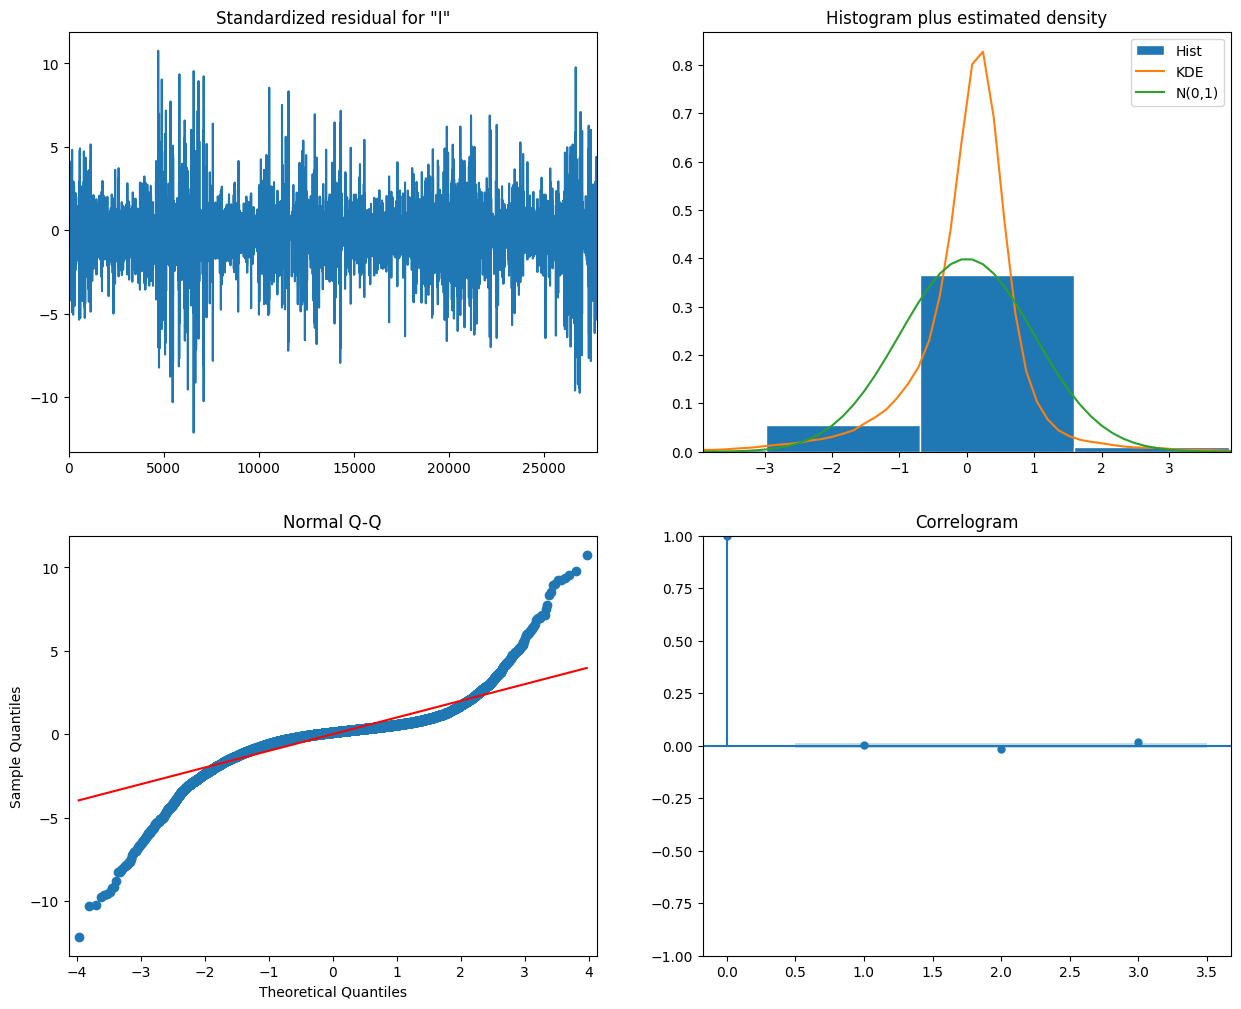

In [18]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

Interprentado los gráficos podemos observar lo siguiente:

    Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
    Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
    Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.
    Abajo a la izquierda: la distrbución ordenada de los residuos sigue una Normal.

## Predicción utilizando el modelo

In [19]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

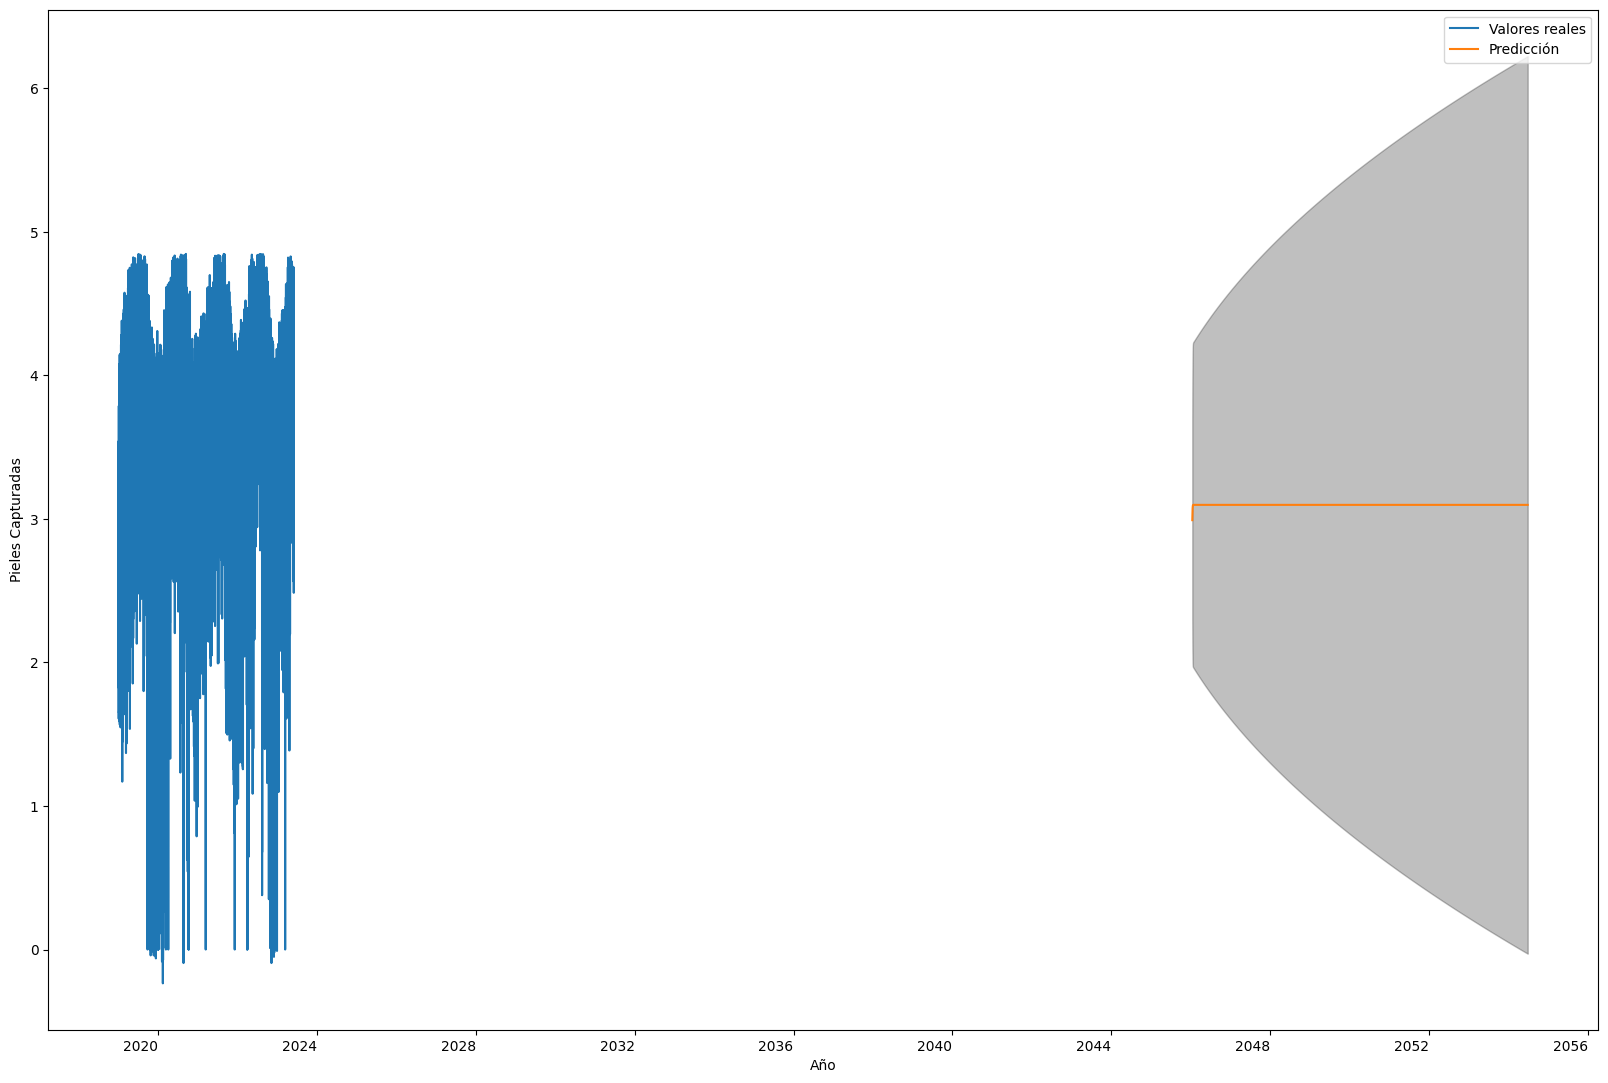

In [20]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [21]:
y_pred = pred_ci.iloc[:, 0]

In [22]:
# El RMSE es de 2.52
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 1, 2), ha dado un rmse en test de 3.3
